<a href="https://colab.research.google.com/github/Raspberry765/deep-metric-learning/blob/main/SubCenterArcFaceMNIST_LoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install torchsummary
!pip install plotly==5.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torchsummary import summary
import plotly.express as px
import plotly.graph_objects as go

In [4]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #MNISTのデータはグレースケールだから、channel数は1である
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        ##torch.nn.functional.max_pool2d(input, kernel_size, stride=kernel_size)
        #max_pool2dのstrideのデフォルトはkernel_size
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))
            numpy_loss = loss.cpu().detach().numpy()
            loss_list.append(numpy_loss)
            #print(numpy_loss)            
    return loss_list


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))




## View some sample outliers

In [5]:


img_mean, img_std = (0.1307,), (0.3081,) #MNISTの平均と標準偏差  https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457 


inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

In [6]:
device = torch.device("cuda")


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(img_mean, img_std)]
) #MNISTの平均と標準偏差を画像に対して前処理を行うためのパラメーター

batch_size = 64

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform) #トランスフォームを適用して、ダウンロード
dataset2 = datasets.MNIST(".", train=False, transform=transform) #トランスフォームを適用して、ダウンロード
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)


test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size) #batch sizeは2**n deep learning C2 w2 optimization algorithms

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)#defalut lr=0.01
num_epochs = 2


### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=128).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

100%|██████████| 9912422/9912422 [00:00<00:00, 100362121.21it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99454592.63it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25295871.97it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21073593.77it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Modelの表示

In [9]:

#print(model)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
Total params: 1,198,592
Trainable params: 1,198,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.57
Estimated Total Size (MB): 5.09
----------------------------------------------------------------


## Train the model

In [12]:
sum_loss_list = []
for epoch in range(1, num_epochs + 1):
    loss_list = train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    print(loss_list)
    sum_loss_list.extend(loss_list)
    test(dataset1, dataset2, model, accuracy_calculator)
print(sum_loss_list)

Epoch 1 Iteration 0: Loss = 38.495479583740234
Epoch 1 Iteration 100: Loss = 6.668646812438965
Epoch 1 Iteration 200: Loss = 2.6553878784179688
Epoch 1 Iteration 300: Loss = 2.3561739921569824
Epoch 1 Iteration 400: Loss = 1.8403894901275635
Epoch 1 Iteration 500: Loss = 3.6157641410827637
Epoch 1 Iteration 600: Loss = 3.1572024822235107
Epoch 1 Iteration 700: Loss = 4.639144420623779
Epoch 1 Iteration 800: Loss = 2.1575634479522705
Epoch 1 Iteration 900: Loss = 1.9492374658584595
[array(38.49548, dtype=float32), array(6.668647, dtype=float32), array(2.6553879, dtype=float32), array(2.356174, dtype=float32), array(1.8403895, dtype=float32), array(3.6157641, dtype=float32), array(3.1572025, dtype=float32), array(4.6391444, dtype=float32), array(2.1575634, dtype=float32), array(1.9492375, dtype=float32)]


100%|██████████| 313/313 [00:03<00:00, 79.31it/s]


Computing accuracy


/usr/local/lib/python3.9/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/usr/local/lib/python3.9/dist-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)


Test set accuracy (Precision@1) = 0.9850000000000001
Epoch 2 Iteration 0: Loss = 1.4808636903762817
Epoch 2 Iteration 100: Loss = 0.6307730078697205
Epoch 2 Iteration 200: Loss = 1.408058524131775
Epoch 2 Iteration 300: Loss = 2.858919620513916
Epoch 2 Iteration 400: Loss = 0.6911453604698181
Epoch 2 Iteration 500: Loss = 2.2211174964904785
Epoch 2 Iteration 600: Loss = 1.6834560632705688
Epoch 2 Iteration 700: Loss = 1.4386787414550781
Epoch 2 Iteration 800: Loss = 0.4372263550758362
Epoch 2 Iteration 900: Loss = 1.7157249450683594
[array(1.4808637, dtype=float32), array(0.630773, dtype=float32), array(1.4080585, dtype=float32), array(2.8589196, dtype=float32), array(0.69114536, dtype=float32), array(2.2211175, dtype=float32), array(1.6834561, dtype=float32), array(1.4386787, dtype=float32), array(0.43722636, dtype=float32), array(1.715725, dtype=float32)]


100%|██████████| 313/313 [00:02<00:00, 114.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9885
[array(38.49548, dtype=float32), array(6.668647, dtype=float32), array(2.6553879, dtype=float32), array(2.356174, dtype=float32), array(1.8403895, dtype=float32), array(3.6157641, dtype=float32), array(3.1572025, dtype=float32), array(4.6391444, dtype=float32), array(2.1575634, dtype=float32), array(1.9492375, dtype=float32), array(1.4808637, dtype=float32), array(0.630773, dtype=float32), array(1.4080585, dtype=float32), array(2.8589196, dtype=float32), array(0.69114536, dtype=float32), array(2.2211175, dtype=float32), array(1.6834561, dtype=float32), array(1.4386787, dtype=float32), array(0.43722636, dtype=float32), array(1.715725, dtype=float32)]


# lossをプロットする

20


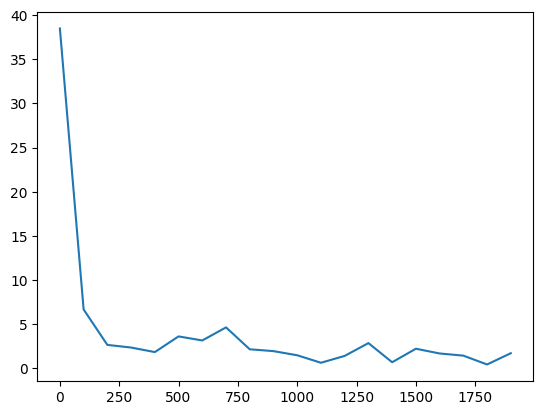

In [21]:
#print(type(loss_list[0]))
print(len(sum_loss_list))
x = np.arange(len(sum_loss_list))*100 #-5から5まで0.1区切りで配列を作る
y = sum_loss_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

plt.plot(x,y) # この場合のplot関数の第一引数xは、x軸に対応し、第二引数のyがy軸にあたります。
plt.show()

In [22]:
fig = go.Figure()
#df = px.data.gapminder().query("continent == 'Oceania'")
fig.add_trace(
go.Scatter(x=x,y=y)
)
fig.update_layout(
    xaxis_title = 'Number of Epoch',
    yaxis_title = 'Loss'
)
fig.show()
#fig = px.line(x, x='year', y='lifeExp', markers=True)
#fig.show()

# modelを保存

In [ ]:
torch.save(model, 'model_dml.pth')

#modelデータのロードをする
# trainデータを埋め込みする



In [ ]:
load_model = torch.load('model_dml.pth')
train_embeddings, train_labels = get_all_embeddings(dataset1, load_model)

100%|██████████| 1875/1875 [00:16<00:00, 111.99it/s]


## Get outliers(MNISTの文字データのtrainデータを異常検知している)

There are 164 outliers


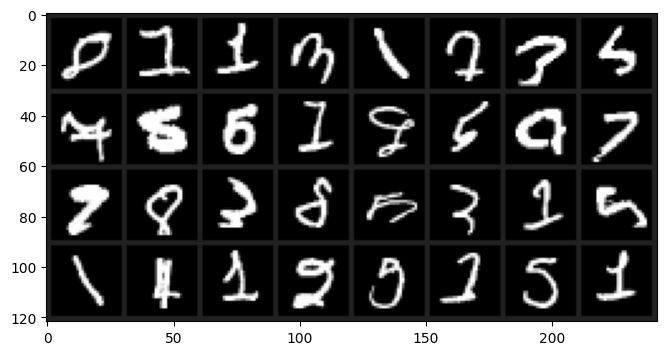

In [ ]:
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers")
imshow_many(dataset1, outliers)

In [ ]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers


# testデータを埋め込みする

In [ ]:
test_embeddings, test_labels = get_all_embeddings(dataset2, model)

100%|██████████| 313/313 [00:02<00:00, 116.46it/s]


## Get outliers(MNISTの文字データのtestデータを異常検知している)

There are 11 outliers(MNIST 10000 test items)


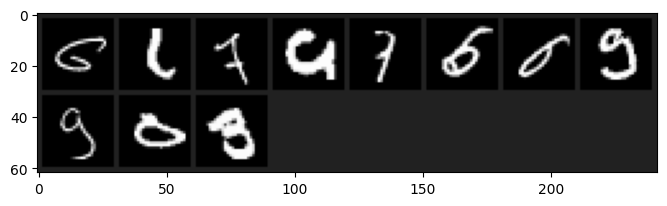

In [ ]:
outliers, _ = loss_func.get_outliers(test_embeddings, test_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(MNIST 10000 test items)")
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
imshow_many(dataset2, outliers)

In [ ]:
# transform to normalize the data
fashion_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
fashion_trainset = datasets.FashionMNIST('.', download=True, train=True, transform=fashion_transform )
fashion_testset = datasets.FashionMNIST('.', download=True, train=False, transform=fashion_transform )

# train fashionデータとtest fashionデータを埋め込みする

In [ ]:
train_fashion_embeddings, train_fashion_labels = get_all_embeddings(fashion_trainset, model)
test_fashion_embeddings, test_fashion_labels = get_all_embeddings(fashion_testset, model)

100%|██████████| 313/313 [00:03<00:00, 102.46it/s]


In [ ]:
outliers, _ = loss_func.get_outliers(train_fashion_embeddings, train_fashion_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(train_fashion 60000 items)")
outliers, _ = loss_func.get_outliers(test_fashion_embeddings, test_fashion_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(train_fashion 10000 items)")

There are 43690 outliers(train_fashion 60000 items)
There are 7319 outliers(train_fashion 10000 items)
